In [1]:
## !pip install holoviews
## !pip install --upgrade bokeh

## pip install git+https://github.com/username/repo.git

In [2]:
## https://docs.microsoft.com/en-us/windows/security/threat-protection/windows-defender-atp/run-advanced-query-api|

In [153]:
def get_secret(secret_name):
    ## implement your getter for fetching the necessary secrets
    return ''

appId = get_secret('WDATP_DEMO_appId')
appSecret = get_secret('WDATP_DEMO_appSecret') 
tenantId = get_secret('WDATP_DEMO_tenantId')

In [117]:
import json
import urllib.request
import urllib.parse
import pandas as pd

import re
from IPython.core.magic import (register_line_magic, register_cell_magic,
                                register_line_cell_magic)
@register_line_cell_magic
def machine(line, cell=None):
    if cell is None:
        return wdatp_api.machines(machineid=line)
    else:    
        results = []
        for f in re.split('[\[\] ;\n\t|,xX"\']',cell):
            p = re.compile('^[a-f0-9]{40}$',re.IGNORECASE)
            if p.search(f) is not None:
                if not f in results:
                    results.append(f)
        
        if len(results) == 0:
            return
        dfs = []
        for machine_id in results:
            dfs.append(wdatp_api.machines(machineid=machine_id))
        import pandas as pd
        return pd.concat(dfs)
            

# We delete these to avoid name conflicts for automagic to work
del machine 

@register_line_cell_magic
def alert(line, cell=None):
    if cell is None:
        return wdatp_api.alerts(alertid=line)
    else:    
        results = []
        for f in re.split('[\[\] ;\n\t|,xX"\']',cell):
            p = re.compile('^[\d]{18}_\-*[\d]{5,16}$',re.IGNORECASE)
            if p.search(f) is not None:
                if not f in results:
                    results.append(f)
        if len(results) == 0:
            return
        dfs = []
        for alert_id in results:
            dfs.append(wdatp_api.alerts(alertid=alert_id))
        import pandas as pd
        return pd.concat(dfs)
            

# We delete these to avoid name conflicts for automagic to work
del alert 

@register_line_cell_magic
def ip(line, cell=None):
    if cell is None:
        return wdatp_api.ips(ip=line)
    else:    
        results = []
        for f in re.split('[\[\] ;\n\t|,xX"\']',cell):
            p = re.compile('^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}$')
            if p.search(f) is not None:
                if not f in results:
                    results.append(f)
        if len(results) == 0:
            return
        dfs = []
        for ip in results:
            dfs.append(wdatp_api.ips(ip=ip))
        import pandas as pd
        return pd.concat(dfs)
            

# We delete these to avoid name conflicts for automagic to work
del ip 
        
class WDATP:
    def __init__(self, tenantId, appId, appSecret, fUsePandas=True, api_root="https://api.securitycenter.windows.com"):
        url = "https://login.windows.net/%s/oauth2/token" % (tenantId)

        self.fDebug = False
        resourceAppIdUri = 'https://api.securitycenter.windows.com'

        body = {
            'resource' : resourceAppIdUri,
            'client_id' : appId,
            'client_secret' : appSecret,
            'grant_type' : 'client_credentials'
        }

        ## authenticate and obtain AAD Token for future calls
        data = urllib.parse.urlencode(body).encode("utf-8")
        req = urllib.request.Request(url, data)
        response = urllib.request.urlopen(req)
        jsonResponse = json.loads(response.read())
        self.aadToken = jsonResponse["access_token"]
        self.headers = { 
            'Content-Type' : 'application/json',
            'Accept' : 'application/json',
            'Authorization' : "Bearer " + self.aadToken
        }
        self.fUsePandas = fUsePandas # use pandas DataFrame for collections of objects, else return a list
        self.api_root = api_root
    
    def set_output_type(self, fUsePandas=True):
        self.fUsePandas = fUsePandas    

    def set_debug_output(self, fDebug=True):
        self.fDebug = fDebug    
        
    def __validate_arguments(self,args, valid_params):
        if len(args) == 0:
            raise ValueError ('argument must be one of %s' % str(list(valid_params.keys())))
        elif len(args) > 1:
            raise ValueError ('only one id can be used at a time')
        else:
            selector = next(iter(args))
            selector_value= next(iter(args.values()))
            if selector not in list(valid_params.keys()):
                raise ValueError ('argument must be one of %s' % str(list(valid_params.keys())))
        return (selector, selector_value)

    def __make_request(self,url):
 
        if self.fDebug:
            print(url)
        
        req = urllib.request.Request(url, headers=self.headers)
        try:
            response = urllib.request.urlopen(req)
        except urllib.error.HTTPError as e:
            if self.fUsePandas:
                return pd.DataFrame()
            else:
                return []
                
        jsonResponse = json.loads(response.read())
        if type(jsonResponse) == int:
            if self.fUsePandas:
                return pd.DataFrame([jsonResponse])
            else:
                return jsonResponse
        if 'value' in jsonResponse:
            res = jsonResponse["value"]
        else:
            res = jsonResponse     
        if self.fUsePandas:
            return pd.io.json.json_normalize(res)
        return res
    
    def alerts(self, **kwargs):
        alert_url = self.api_root + "/api/alerts"
        
        valid_params = {
            'filterstr' : alert_url + '?%s',
            'alertid' : alert_url + '/%s',
            'userid'    : self.api_root + '/api/users/%s/alerts',
            'ip'        : self.api_root + '/api/ips/%s/alerts',
            'machineid'   : self.api_root + '/api/machines/%s/alerts',
            'filesha1'  : self.api_root + '/api/files/%s/alerts', 
            'domain'    : self.api_root + '/api/domains/%s/alerts' 
        }
        (selector, selector_value) = self.__validate_arguments(kwargs, valid_params)
             
        url = valid_params[selector] % selector_value        

        return self.__make_request(url)
    
    def machines(self, **kwargs):
        machine_url = self.api_root + "/api/machines"
        
        valid_params = {
            'filterstr' : machine_url + '%s',
            'machineid' : machine_url + '/%s',
            'userid'    : self.api_root + '/api/users/%s/machines',
            'ip'        : self.api_root + '/api/ips/%s/machines',
            'alertid'   : self.api_root + '/api/alerts/%s/machine',
            'filesha1'  : self.api_root + '/api/files/%s/machines', 
            'domain'    : self.api_root + '/api/domains/%s/machines',
            'ip_timestamp' : self.api_root + '/api/machines/findbyip(ip=\'%s\',timestamp=%s)'

        }
        
        (selector, selector_value) = self.__validate_arguments(kwargs, valid_params)
        
        if selector == 'ip_timestamp':
            url = valid_params[selector] % (selector_value.split('#')[0], selector_value.split('#')[1])
        else:
            url = valid_params[selector] % selector_value

        return self.__make_request(url)
    
    def ips(self, **kwargs):
        ips_url = self.api_root + "/api/ips"
        
        valid_params = {
            'filterstr' : ips_url + '?%s',
            'ip'    : ips_url + '/%s/stats'
        }
        
        (selector, selector_value) = self.__validate_arguments(kwargs, valid_params)
        
        url = valid_params[selector] % selector_value

        return self.__make_request(url)
    
    def users(self, **kwargs):
        user_url = self.api_root + "/api/users"
        
        valid_params = {
            'filterstr' : user_url + '?%s',
            'userid'    : user_url + '/%s',
            'machineid' : self.api_root + '/api/machines/%s/logonusers',
            'alertid'   : self.api_root + '/api/alerts/%s/user'
        }
        
        (selector, selector_value) = self.__validate_arguments(kwargs, valid_params)
        
        url = valid_params[selector] % selector_value

        return self.__make_request(url)
     
    def files(self, **kwargs):
        user_url = self.api_root + "/api/files/"
        
        valid_params = {
            'filehash' : user_url + '?%s',
            'alertid'   : self.api_root + '/api/alerts/%s/files'
        }
        
        (selector, selector_value) = self.__validate_arguments(kwargs, valid_params)
        
        url = valid_params[selector] % selector_value

        return self.__make_request(url)
    
    def query(self, query):
        url = self.api_root + "/api/advancedqueries/run"
        data = json.dumps({ 'Query' : query }).encode("utf-8")
        req = urllib.request.Request(url, data, self.headers)
        response = urllib.request.urlopen(req)
        jsonResponse = json.loads(response.read())
        res = jsonResponse["Results"]
        if self.fUsePandas:
            return pd.io.json.json_normalize(res)
        return res

In [80]:
wdatp_api = WDATP(tenantId, appId, appSecret)

In [82]:
wdatp_api.set_debug_output(True)

## Getting Alerts

Let's query the most recent 5 alerts using the OData TOP keyword

In [120]:
wdatp_api.alerts(filterstr = "$top=5")

actorName             alertCreationTime  \
0      None  2018-11-19T14:55:15.4568768Z   
1      None   2018-08-15T08:42:51.503207Z   
2      None  2018-11-14T15:33:57.9111767Z   
3      None  2018-11-19T12:46:01.2838143Z   
4      None  2018-11-19T12:24:27.5503626Z   

                            assignedTo            category classification  \
0                                 None  SuspiciousActivity           None   
1  dalaufer@wcdtestprd.onmicrosoft.com         Persistence           None   
2                                 None  SuspiciousActivity           None   
3                                 None             General           None   
4                                 None  SuspiciousActivity           None   

                                         description         detectionSource  \
0  A suspicious behavior by a system utility was ...      WindowsDefenderAtp   
1  A system program was registered as a service. ...      WindowsDefenderAtp   
2  This file was first found and identified to be...  AutomatedInvestigation   
3  Malware and unwanted software are undesirable ...       WindowsDefenderAv   
4  A suspicious behavior by a system utility was ...      WindowsDefenderAtp   

  determination                firstEventTime                              id  \
0          None  2018-11-19T14:52:57.6619172Z  636782361156912644_-1659958896   
1          None  2018-08-15T08:40:27.8909992Z  636699193721372537_-1589535307   
2          None  2018-11-14T15:33:57.5931648Z    636778064390205585_534213375   
3          None  2018-11-19T09:21:43.0420067Z    636782283616148055_944897573   
4          None  2018-11-19T12:22:15.9093979Z    636782270676753868_431036474   

                  lastEventTime                                 machineId  \
0  2018-11-19T14:54:20.3517813Z  38f5a40728148cbd9e37c584fd1fdc34648418f7   
1  2018-11-19T14:36:27.2277835Z  348037e35b2f0061c3d73eea20e59592d66c1bd7   
2   2018-11-19T13:55:36.065728Z  0b609fa6256876ebeb4ba1d569c0e7358061e826   
3  2018-11-19T13:37:28.5762046Z  03c67a60ce7598a11ab7529541679edf621e58f1   
4  2018-11-19T12:22:50.3152945Z  534e44ce350ced8c44a8da9a88ad5f36b8830944   

                                   recommendedAction resolvedTime  \
0  1. Inspect processes and files in the executio...         None   
1  A. Validate the alert and scope the suspected ...         None   
2                                                            None   
3  Collect artifacts and determine scope\n•\tRevi...         None   
4  1. Inspect processes and files in the executio...         None   

        severity      status threatFamilyName  \
0         Medium         New             None   
1         Medium  InProgress             None   
2  Informational         New             None   
3  Informational         New  EICAR_Test_File   
4         Medium         New             None   

                                               title  
0  Suspicious behavior by a system utility was ob...  
1                    Suspicious service registration  
2  Possible discovery of malicious file copy by A...  
3  Windows Defender AV detected 'EICAR_Test_File'...  
4  Suspicious behavior by a system utility was ob...

The results are returned as a Pandas DataFrame--a handy data structure for processing rowset oriented results. If you don't want the results in a DataFrame and instead just in a list, you can set fUsePandas=False when you create the WDATP class.

See the [Pandas project page](https://pandas.pydata.org/pandas-docs/stable/index.html) for more information on DataFrames.

In [121]:
# Let's select just the columns we want to view

wdatp_api.alerts(filterstr = "$top=5")[['alertCreationTime','category','title','description','id','severity']]

alertCreationTime            category  \
0  2018-11-19T14:55:15.4568768Z  SuspiciousActivity   
1   2018-08-15T08:42:51.503207Z         Persistence   
2  2018-11-14T15:33:57.9111767Z  SuspiciousActivity   
3  2018-11-19T12:46:01.2838143Z             General   
4  2018-11-19T12:24:27.5503626Z  SuspiciousActivity   

                                               title  \
0  Suspicious behavior by a system utility was ob...   
1                    Suspicious service registration   
2  Possible discovery of malicious file copy by A...   
3  Windows Defender AV detected 'EICAR_Test_File'...   
4  Suspicious behavior by a system utility was ob...   

                                         description  \
0  A suspicious behavior by a system utility was ...   
1  A system program was registered as a service. ...   
2  This file was first found and identified to be...   
3  Malware and unwanted software are undesirable ...   
4  A suspicious behavior by a system utility was ...   

                               id       severity  
0  636782361156912644_-1659958896         Medium  
1  636699193721372537_-1589535307         Medium  
2    636778064390205585_534213375  Informational  
3    636782283616148055_944897573  Informational  
4    636782270676753868_431036474         Medium

In [122]:
# let's assign the API results to a variable so we can process them without making an API call each time
df = wdatp_api.alerts(filterstr = "$top=100")
print("number of rows returned = %d" % len(df))

number of rows returned = 100


In [123]:
# show all the columns in the alert
df.columns

Index(['actorName', 'alertCreationTime', 'assignedTo', 'category',
       'classification', 'description', 'detectionSource', 'determination',
       'firstEventTime', 'id', 'lastEventTime', 'machineId',
       'recommendedAction', 'resolvedTime', 'severity', 'status',
       'threatFamilyName', 'title'],
      dtype='object')

In [124]:
# let's group them by title and count their frequency
df1 = df[['id','title']].groupby('title').count().rename(index=str, columns={"id":"Alert Count"})
df1

Alert Count
title                                                          
A powershell script with suspicious content was...            1
A suspicious file was observed                                2
Possible discovery of malicious file copy by Au...            1
Sensitive credential memory read                             16
Suspicious behavior by a system utility was obs...           32
Suspicious service registration                               8
Windows Defender AV detected 'EICAR_Test_File' ...            7
Windows Defender AV detected 'PSAttackTool' mal...            1
[Test alert] WDATP Initiate an Automated Invest...           31
[Test] Hunting alert                                          1

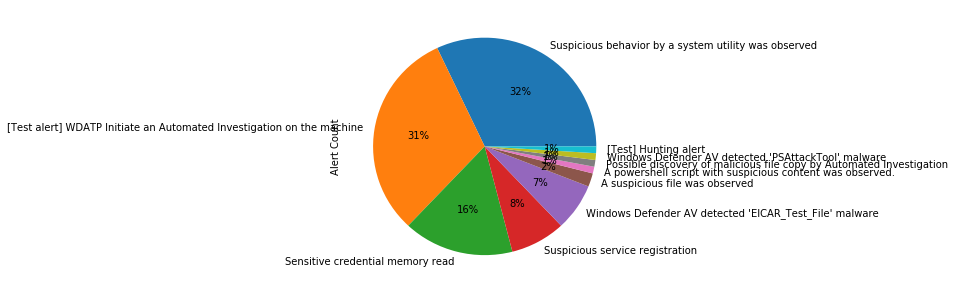

In [125]:
# show a quick pie chart using matplotlib
%matplotlib inline
df1 = df1.sort_values(['Alert Count'], ascending=False)
plt = df1.plot.pie(y=0, figsize=(5, 5), legend=False, autopct='%1.0f%%')

## WDATP and Jupyter Magics

Lines starting with % signify a Jupyter magic. A "line magic" take the text after the command and does something with it. 

%alert takes an alert id and calls the API to get details about it

In [126]:
%alert 636740134254933385_-1113968221

@odata.context actorName  \
0  https://api.securitycenter.windows.com/api/$me...      None   

              alertCreationTime assignedTo category classification  \
0  2018-10-01T17:57:05.0833927Z       None  Malware           None   

                                         description     detectionSource  \
0  A known malicious driver was loaded. By loadin...  WindowsDefenderAtp   

  determination                firstEventTime                              id  \
0          None  2018-10-01T17:56:01.8373153Z  636740134254933385_-1113968221   

                  lastEventTime                                 machineId  \
0  2018-10-29T18:43:15.8038762Z  80102a08edaa9e2aa875abb5d787db5064cc5246   

                                   recommendedAction resolvedTime severity  \
0  Validate the alert, collect artifacts, and det...         None     High   

  status threatFamilyName                                title  
0    New             None  A known malicious driver was loaded

In [127]:
# output from the previous command is stored in an automatic variable, the understore _
alert_df = _
alert_df.T  # Transpose rows and columsn for an easy way to view the alert details

0
@odata.context     https://api.securitycenter.windows.com/api/$me...
actorName                                                       None
alertCreationTime                       2018-10-01T17:57:05.0833927Z
assignedTo                                                      None
category                                                     Malware
classification                                                  None
description        A known malicious driver was loaded. By loadin...
detectionSource                                   WindowsDefenderAtp
determination                                                   None
firstEventTime                          2018-10-01T17:56:01.8373153Z
id                                    636740134254933385_-1113968221
lastEventTime                           2018-10-29T18:43:15.8038762Z
machineId                   80102a08edaa9e2aa875abb5d787db5064cc5246
recommendedAction  Validate the alert, collect artifacts, and det...
resolvedTime                                                    None
severity                                                        High
status                                                           New
threatFamilyName                                                None
title                            A known malicious driver was loaded

In [128]:
#lookup the mahcine in the above alert
%machine 80102a08edaa9e2aa875abb5d787db5064cc5246

@odata.context aadDeviceId  \
0  https://api.securitycenter.windows.com/api/$me...        None   

         agentVersion               computerDnsName  \
0  10.5800.17708.1001  msticres-w19x13.msticres.net   

                      firstSeen healthStatus  \
0  2018-08-03T20:42:34.8343598Z     Inactive   

                                         id  isAadJoined  \
0  80102a08edaa9e2aa875abb5d787db5064cc5246        False   

  lastExternalIpAddress lastIpAddress                     lastSeen  \
0       131.107.174.133      10.0.0.5  2018-10-29T17:37:19.508408Z   

  machineTags  osBuild         osPlatform osVersion  rbacGroupId  \
0          []    17708  WindowsServer2019      None            1   

     rbacGroupName riskScore  
0  UnassignedGroup      High

In [130]:
alert = alert_df.T.to_dict()[0]

get_records_qry = '''
// AlertId %s
let pivotTimeParam = datetime('%s');
let machine_id = '%s';
ProcessCreationEvents
| where EventTime between ((pivotTimeParam-15m) ..15m)
| where MachineId  == machine_id
| take 100
''' % (alert['id'], alert['alertCreationTime'], alert['machineId'])
print (get_records_qry)

wdatp_api.query(query=get_records_qry)


// AlertId 636740134254933385_-1113968221
let pivotTimeParam = datetime('2018-10-01T17:57:05.0833927Z');
let machine_id = '80102a08edaa9e2aa875abb5d787db5064cc5246';
ProcessCreationEvents
| where EventTime between ((pivotTimeParam-15m) ..15m)
| where MachineId  == machine_id
| take 100



Empty DataFrame
Columns: []
Index: []

In [56]:
%%ip 
Let's check for any communication to some IPs. I can include any text here I 
want because the Jupyter magic for ip will regex extract IPv4 addresses and
look them up
52.239.151.138
65.52.108.90
end of list of IPs

@odata.context       ipAddress  \
0  https://api.securitycenter.windows.com/api/$me...  52.239.151.138   
0  https://api.securitycenter.windows.com/api/$me...    65.52.108.90   

           orgFirstSeen           orgLastSeen orgPrevalence  
0  2018-10-20T16:32:47Z  2018-11-19T13:23:39Z           492  
0  2018-10-20T16:27:44Z  2018-11-19T16:16:07Z          6586

## Visualize WDATP data with Holoviews

Holoviews is an open source visualization library for Python. In this example we select a set of machines (desktops and servers)
and get a list of the netblocks they are communicating with.  We render the data in a Chord diagram. This makes it easy to see
the flows of information and quickly grasp who is talking to whom.

This kind of visualization can be useful to plot the communication patterns of a set of machines that should be fairly similar 
(Domain controllers, databases, HR servers) and quickly see outliers

In [144]:
query = '''
let masked_machine_list1 = MachineInfo | where EventTime > ago(1d) | where ComputerName contains 'sqlsvr' | summarize by MachineId | take 10 | serialize | extend MaskedComputerName = strcat('svr_' , row_number());
let masked_machine_list2 = MachineInfo | where EventTime > ago(1d) | where ComputerName startswith 'desktop' | summarize by MachineId | take 10 | serialize | extend MaskedComputerName = strcat('desktop_' , row_number());
let masked_machine_list = masked_machine_list1 | union masked_machine_list2;
NetworkCommunicationEvents
| where EventTime > ago(5d) | where isnotempty(MachineId)
| where RemoteIPType == 'Public' and RemoteIP contains ('.') and RemotePort in ('80') 
| extend MaskedIP = strcat(split(RemoteIP,'.')[0],'.', split(RemoteIP,'.')[1], '.*.*')
| summarize by MachineId, MaskedIP 
| join kind=inner (masked_machine_list) on MachineId 
| summarize by MaskedComputerName, MaskedIP
'''
df = wdatp_api.query(query)
print ("rows returned = %d" % len(df))

rows returned = 249


Plot a basic Chord diagram. Note, this one will have no labels or colors.

In [145]:
%opts Chord [width=800 height=800]

import holoviews as hv
hv.Chord((df))

:Chord   [MaskedComputerName,MaskedIP]

Let's add some colors and labels to the diagram

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
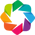

:Chord   [source,dest]

In [140]:
## this does some footwork for holoviews to allow us to format the colors, nodes, and edges.

import holoviews as hv
hv.extension('bokeh')

def holoview_charting_objects(df):
    g1 = list(df[df.columns[0]].astype(str).unique())
    g2 = list(df[df.columns[1]].astype(str).unique())
    g1d = list(map(lambda x: {'name': x, 'group':1}, g1))
    g2d = list(map(lambda x: {'name': x, 'group':2}, g2))
    nodes = hv.Dataset(pd.DataFrame(g1d + g2d), 'index')

    src = list(map(lambda x: nodes.data[nodes.data['name'] == x]['index'].values[0], list(df[df.columns[0]].values)))
    dst = list(map(lambda x: nodes.data[nodes.data['name'] == x]['index'].values[0], list(df[df.columns[1]].values)))
    df2 = pd.DataFrame(list(zip(src,dst)), columns=['source','dest'])
    return (df2, nodes)

%opts Chord [width=800 height=800]
%opts Chord [label_index='name' color_index='index' edge_color_index='source'] 
%opts Chord (cmap='Category20' edge_cmap='Category20')

import holoviews as hv
hv.Chord(holoview_charting_objects(df))

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
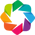

:Scatter   [MaskedComputerName]   (MaskedIP)

In [146]:
# we can also render the same data in a Scatter plot

%opts Scatter [width=800 height=800] (size=10)
import holoviews as hv
hv.extension('bokeh')
hv.Scatter(df).options(show_grid=True)

## Query alerts and machine details then render a graph showing alerts and machines

In [148]:
# get top 10 alerts and then get all the machines associated with them

df_alerts = wdatp_api.alerts(filterstr = '$top=10')
df_alerts[['category','description','title','detectionSource','id','machineId']]
machines = df_alerts.machineId.unique().tolist()
machines

['38f5a40728148cbd9e37c584fd1fdc34648418f7',
 '348037e35b2f0061c3d73eea20e59592d66c1bd7',
 '0b609fa6256876ebeb4ba1d569c0e7358061e826',
 '03c67a60ce7598a11ab7529541679edf621e58f1',
 '534e44ce350ced8c44a8da9a88ad5f36b8830944',
 'eebea3a35de9b8c137d80f53d3266b3d949782c4',
 '7287db2144d82bf52630d0741720060a56f5dd0e',
 '39ab7f312124dfb6da21170a0253c42b76f1ba3a',
 '734f84807b88ce4e808fed975dedafc96a699859']

In [149]:
## loop through the machines and use the WDATP API to retrieve details about them 

wdatp_api.set_output_type(False)
import pprint
pp = pprint.PrettyPrinter(indent=4)
for machineid in machines:
    mach_obj = wdatp_api.machines(machineid = machineid)
    pp.pprint(mach_obj)

{   '@odata.context': 'https://api.securitycenter.windows.com/api/$metadata#Machines/$entity',
    'aadDeviceId': None,
    'agentVersion': '10.6300.18286.1000',
    'computerDnsName': 'tk5-3wp16r1716.fscttest.nttest.microsoft.com',
    'firstSeen': '2018-11-19T14:52:42.7438658Z',
    'healthStatus': 'Active',
    'id': '38f5a40728148cbd9e37c584fd1fdc34648418f7',
    'isAadJoined': False,
    'lastExternalIpAddress': '131.107.160.1',
    'lastIpAddress': '10.231.45.1',
    'lastSeen': '2018-11-19T15:40:36.1629576Z',
    'machineTags': [],
    'osBuild': 18286,
    'osPlatform': 'WindowsServer2019',
    'osVersion': None,
    'rbacGroupId': 1,
    'rbacGroupName': 'UnassignedGroup',
    'riskScore': 'Medium'}
{   '@odata.context': 'https://api.securitycenter.windows.com/api/$metadata#Machines/$entity',
    'aadDeviceId': None,
    'agentVersion': '10.6400.18284.1000',
    'computerDnsName': 'eshany-test2.middleeast.corp.microsoft.com',
    'firstSeen': '2016-09-14T11:56:30.4496709Z',
  

In [150]:
## now build the data we need for the graph

import pprint
pp = pprint.PrettyPrinter(indent=4)
wdatp_api.set_output_type(fUsePandas = True)

df_alerts = wdatp_api.alerts(filterstr = '$top=20')
alert_ids = df_alerts.id.unique().tolist()
wdatp_api.set_output_type(fUsePandas = False)


L = []
for alert_id in alert_ids:
    obj = wdatp_api.machines(alertid = alert_id)
    L.append((alert_id, obj['id']))

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
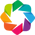

:Graph   [start,end]

In [151]:
## TODO: render the indexes as friendly strings (machines and alert Titles)

import pandas as pd
import holoviews as hv
import networkx as nx
import numpy as np

g = list( map(list, zip(*L)))
g1 = g[0]
g2 = g[1]
g1d = list(map(lambda x: {'name': x, 'group':1}, g1))
g2d = list(map(lambda x: {'name': x, 'group':2}, list(set(g2))))
nodes = hv.Dataset(pd.DataFrame(g1d + g2d), 'index')
src = list(map(lambda x: nodes.data[nodes.data['name'] == x]['index'].values[0], g1))
dst = list(map(lambda x: nodes.data[nodes.data['name'] == x]['index'].values[0], g2))
df2 = pd.DataFrame(list(zip(src,dst)), columns=['source','dest'])

node_indices = list(nodes.data.index)

hv.extension('bokeh')

%opts Graph [width=800 height=600]
padding = dict(x=(-1.2, 1.2), y=(-1.2, 1.2))

colors = ['#000000']+hv.Cycle('Category20').values

simple_graph = hv.Graph(((src, dst),)).redim.range(**padding).options(cmap=colors)
simple_graph